In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess the datasets
train_data = pd.read_csv('Train.csv')  
test_data = pd.read_csv('Test.csv')  

# Drop unnecessary columns in both datasets
train_data = train_data.drop(columns=['Date'])
test_data = test_data.drop(columns=['Date'])

In [3]:
# Create lag features for 'S10' in the training data
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data


In [4]:

train_data = create_lag_features(train_data, 'S10', n_lags=3).dropna()
X_train = train_data.drop(columns=['S10']).values
y_train = train_data['S10'].values

# Create lag features for 'S10' in the testing data
test_data = create_lag_features(test_data, 'S10', n_lags=3).dropna()
X_test = test_data.drop(columns=['S10']).values
y_test = test_data['S10'].values

In [5]:
# Scale target variable (y)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for RNN input
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [7]:
#Custom function to train LSTM and BiLSTM
def build_and_train_rnn_model(model_type, X_train, y_train, X_test):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(200, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "BiLSTM":
        model.add(Bidirectional(LSTM(200, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.1, verbose=0)
    return scaler_y.inverse_transform(model.predict(X_test).flatten().reshape(-1, 1)).flatten()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Stacked Model Results (LSTM + BiLSTM with XGBoost Meta-Model):
Mean Squared Error (MSE): 558.7186276664885
Root Mean Squared Error (RMSE): 23.637229695260157
R-Squared (R²): 0.7841912404084321


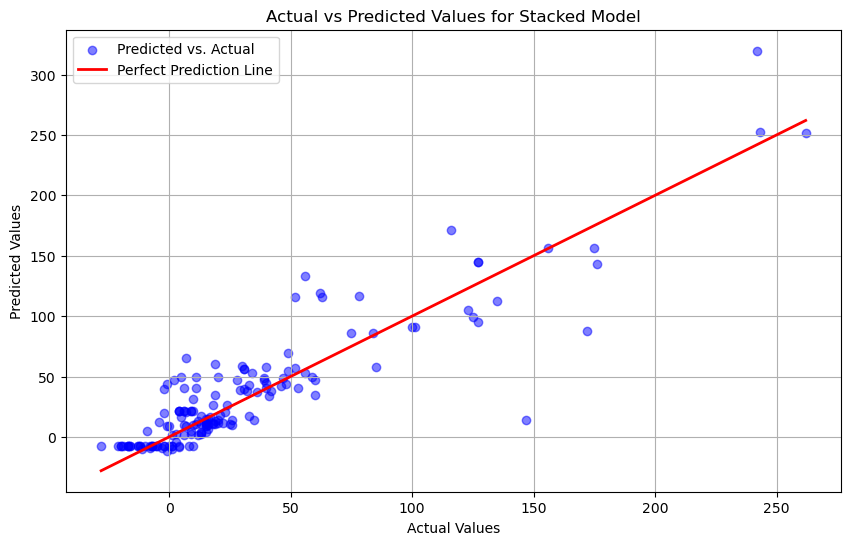

In [9]:
# Get predictions from both models
from sklearn.model_selection import train_test_split

# Get predictions from both models for training and testing datasets
predictions_lstm_train = build_and_train_rnn_model("LSTM", X_train_rnn, y_train_scaled, X_train_rnn)
predictions_bilstm_train = build_and_train_rnn_model("BiLSTM", X_train_rnn, y_train_scaled, X_train_rnn)

predictions_lstm_test = build_and_train_rnn_model("LSTM", X_train_rnn, y_train_scaled, X_test_rnn)
predictions_bilstm_test = build_and_train_rnn_model("BiLSTM", X_train_rnn, y_train_scaled, X_test_rnn)

# Combine LSTM and BiLSTM predictions for training set for meta-model
stacked_predictions_train = np.column_stack([predictions_lstm_train, predictions_bilstm_train])
stacked_predictions_test = np.column_stack([predictions_lstm_test, predictions_bilstm_test])

# Split the stacked predictions and y_train into training and validation sets for the meta-model
stacked_X_train, stacked_X_val, stacked_y_train, stacked_y_val = train_test_split(stacked_predictions_train, y_train.flatten(), test_size=0.2, random_state=42)

# Train the meta-model on the training portion of the stacked predictions
meta_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
meta_model.fit(stacked_X_train, stacked_y_train)

# Make final predictions using the meta-model on the test set stacked predictions
final_predictions = meta_model.predict(stacked_predictions_test)

# Evaluate on the actual test set labels
mse = mean_squared_error(y_test.flatten(), final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test.flatten(), final_predictions)

print("Stacked Model Results (LSTM + BiLSTM with XGBoost Meta-Model):")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared (R²): {r2}")

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.flatten(), final_predictions, alpha=0.5, color='blue', label='Predicted vs. Actual')
plt.plot([min(y_test.flatten()), max(y_test.flatten())], [min(y_test.flatten()), max(y_test.flatten())], color='red', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Stacked Model')
plt.legend()
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing


Stacked Model Results (LSTM, BiLSTM, RNN, BiRNN, ARMA, ARIMA, Prophet with XGBoost Meta-Model):
Mean Squared Error (MSE): 337.62342210492795
Root Mean Squared Error (RMSE): 18.374531888048956
R-Squared (R²): 0.8695907236208745


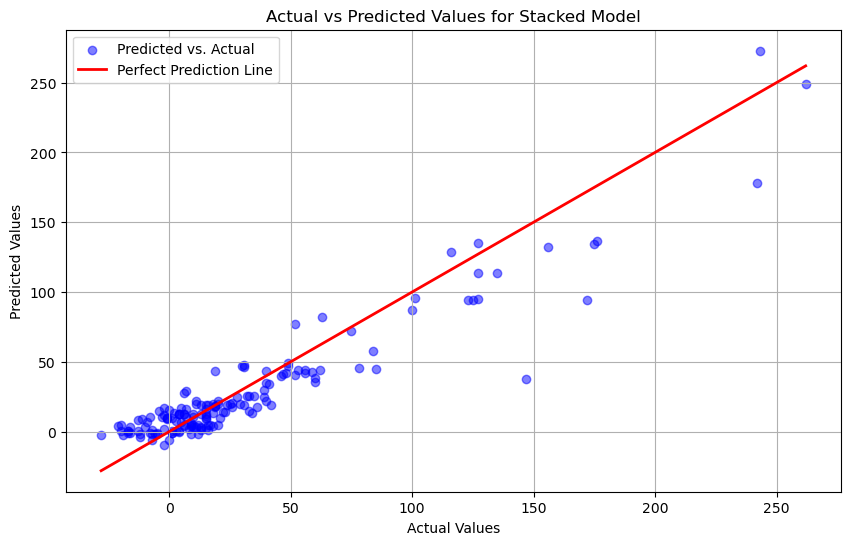

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from prophet import Prophet
from sklearn.model_selection import train_test_split

# Load and preprocess the datasets
train_data = pd.read_excel('Train_Data.xlsx')  # Replace with your training data file name
test_data = pd.read_excel('Test_Data.xlsx')  # Replace with your testing data file name

# Drop unnecessary columns in both datasets
train_data = train_data.drop(columns=['Date'])
test_data = test_data.drop(columns=['Date'])

# Create lag features for 'S10' in the training data
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

train_data = create_lag_features(train_data, 'S10', n_lags=3).dropna()
X_train = train_data.drop(columns=['S10']).values
y_train = train_data['S10'].values

# Create lag features for 'S10' in the testing data
test_data = create_lag_features(test_data, 'S10', n_lags=3).dropna()
X_test = test_data.drop(columns=['S10']).values
y_test = test_data['S10'].values

# Scale target variable (y)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for RNN input
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to train RNN-based models (LSTM, BiLSTM, RNN, BiRNN)
def build_and_train_rnn_model(model_type, X_train, y_train, X_test):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(200, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "BiLSTM":
        model.add(Bidirectional(LSTM(200, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "RNN":
        model.add(SimpleRNN(200, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "BiRNN":
        model.add(Bidirectional(SimpleRNN(200, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.1, verbose=0)
    return scaler_y.inverse_transform(model.predict(X_test).flatten().reshape(-1, 1)).flatten()

# Get predictions for training and test sets from each model
predictions_lstm_train = build_and_train_rnn_model("LSTM", X_train_rnn, y_train_scaled, X_train_rnn)
predictions_bilstm_train = build_and_train_rnn_model("BiLSTM", X_train_rnn, y_train_scaled, X_train_rnn)
predictions_rnn_train = build_and_train_rnn_model("RNN", X_train_rnn, y_train_scaled, X_train_rnn)
predictions_birnn_train = build_and_train_rnn_model("BiRNN", X_train_rnn, y_train_scaled, X_train_rnn)

predictions_lstm_test = build_and_train_rnn_model("LSTM", X_train_rnn, y_train_scaled, X_test_rnn)
predictions_bilstm_test = build_and_train_rnn_model("BiLSTM", X_train_rnn, y_train_scaled, X_test_rnn)
predictions_rnn_test = build_and_train_rnn_model("RNN", X_train_rnn, y_train_scaled, X_test_rnn)
predictions_birnn_test = build_and_train_rnn_model("BiRNN", X_train_rnn, y_train_scaled, X_test_rnn)

# Train and predict using ARMA model
arma_model = AutoReg(y_train, lags=3).fit()
predictions_arma_train = arma_model.predict(start=0, end=len(y_train) - 1)
predictions_arma_test = arma_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Train and predict using ARIMA model
arima_model = ARIMA(y_train, order=(3, 1, 0)).fit()
predictions_arima_train = arima_model.predict(start=0, end=len(y_train) - 1)
predictions_arima_test = arima_model.forecast(steps=len(y_test))

# Prophet model
train_df = pd.DataFrame({'ds': pd.date_range(start='2022-01-01', periods=len(y_train)), 'y': y_train})
test_df = pd.DataFrame({'ds': pd.date_range(start='2022-01-01', periods=len(y_test))})
prophet_model = Prophet()
prophet_model.fit(train_df)
prophet_forecast_train = prophet_model.predict(train_df)
prophet_forecast_test = prophet_model.predict(test_df)
predictions_prophet_train = prophet_forecast_train['yhat'].values
predictions_prophet_test = prophet_forecast_test['yhat'].values

# Combine all model predictions for stacking
stacked_predictions_train = np.column_stack([
    predictions_lstm_train,
    predictions_bilstm_train,
    predictions_rnn_train,
    predictions_birnn_train,
    predictions_arma_train[:len(predictions_lstm_train)],
    predictions_arima_train,
    predictions_prophet_train
])

stacked_predictions_test = np.column_stack([
    predictions_lstm_test,
    predictions_bilstm_test,
    predictions_rnn_test,
    predictions_birnn_test,
    predictions_arma_test,
    predictions_arima_test,
    predictions_prophet_test
])

# Train the meta-model using only the stacked training predictions
stacked_X_train, stacked_X_val, stacked_y_train, stacked_y_val = train_test_split(stacked_predictions_train, y_train, test_size=0.2, random_state=42)
meta_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
meta_model.fit(stacked_X_train, stacked_y_train)

# Final predictions using the meta-model on the test set
final_predictions = meta_model.predict(stacked_predictions_test)

# Evaluate on the actual test set labels
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, final_predictions)

print("Stacked Model Results (LSTM, BiLSTM, RNN, BiRNN, ARMA, ARIMA, Prophet with XGBoost Meta-Model):")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared (R²): {r2}")

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, alpha=0.5, color='blue', label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Stacked Model')
plt.legend()
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
LSTM - RMSE: 23.192944612990136
BiLSTM - RMSE: 25.110571843125392
RNN - RMSE: 21.49258988055603
BiRNN - RMSE: 19.886097617332705

Selected models for stacking:
['RNN', 'BiRNN']

Final Stacked Model Results (after removing deviating models):
Mean Squared Error (MSE): 690.4155828995961
Root Mean Squared Error (RMSE): 26.275760367677204
R-Squared (R²): 0.7333224217518104


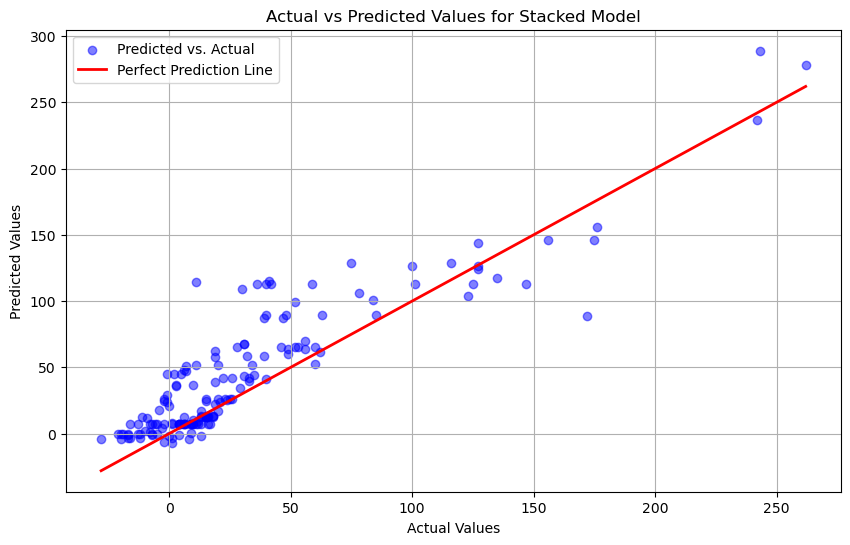

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load and preprocess the datasets
train_data = pd.read_excel('Train_Data.xlsx')  # Replace with your training data file name
test_data = pd.read_excel('Test_Data.xlsx')  # Replace with your testing data file name

# Drop unnecessary columns in both datasets
train_data = train_data.drop(columns=['Date'])
test_data = test_data.drop(columns=['Date'])

# Create lag features for 'S10' in the training data
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

train_data = create_lag_features(train_data, 'S10', n_lags=3).dropna()
X_train = train_data.drop(columns=['S10']).values
y_train = train_data['S10'].values

# Create lag features for 'S10' in the testing data
test_data = create_lag_features(test_data, 'S10', n_lags=3).dropna()
X_test = test_data.drop(columns=['S10']).values
y_test = test_data['S10'].values

# Scale target variable (y)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for RNN input
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to train RNN-based models (LSTM, BiLSTM, RNN, BiRNN)
def build_and_train_rnn_model(model_type, X_train, y_train, X_test):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(200, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "BiLSTM":
        model.add(Bidirectional(LSTM(200, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "RNN":
        model.add(SimpleRNN(200, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "BiRNN":
        model.add(Bidirectional(SimpleRNN(200, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.1, verbose=0)
    return scaler_y.inverse_transform(model.predict(X_test).flatten().reshape(-1, 1)).flatten()

# Get predictions for training and test sets from each model
predictions_lstm_train = build_and_train_rnn_model("LSTM", X_train_rnn, y_train_scaled, X_train_rnn)
predictions_bilstm_train = build_and_train_rnn_model("BiLSTM", X_train_rnn, y_train_scaled, X_train_rnn)
predictions_rnn_train = build_and_train_rnn_model("RNN", X_train_rnn, y_train_scaled, X_train_rnn)
predictions_birnn_train = build_and_train_rnn_model("BiRNN", X_train_rnn, y_train_scaled, X_train_rnn)

predictions_lstm_test = build_and_train_rnn_model("LSTM", X_train_rnn, y_train_scaled, X_test_rnn)
predictions_bilstm_test = build_and_train_rnn_model("BiLSTM", X_train_rnn, y_train_scaled, X_test_rnn)
predictions_rnn_test = build_and_train_rnn_model("RNN", X_train_rnn, y_train_scaled, X_test_rnn)
predictions_birnn_test = build_and_train_rnn_model("BiRNN", X_train_rnn, y_train_scaled, X_test_rnn)

# Function to evaluate models
def evaluate_models(y_true, model_predictions):
    model_errors = {}
    for model_name, predictions in model_predictions.items():
        # Handle NaNs by filling with the median value of predictions
        if np.isnan(predictions).any():
            predictions = np.nan_to_num(predictions, nan=np.nanmedian(predictions))
        mse = mean_squared_error(y_true, predictions)
        rmse = np.sqrt(mse)
        model_errors[model_name] = rmse
        print(f"{model_name} - RMSE: {rmse}")
    return model_errors

# Gather predictions for each model
model_predictions_train = {
    "LSTM": predictions_lstm_train,
    "BiLSTM": predictions_bilstm_train,
    "RNN": predictions_rnn_train,
    "BiRNN": predictions_birnn_train
}

model_predictions_test = {
    "LSTM": predictions_lstm_test,
    "BiLSTM": predictions_bilstm_test,
    "RNN": predictions_rnn_test,
    "BiRNN": predictions_birnn_test
}

# Evaluate each model’s performance on the training data
train_errors = evaluate_models(y_train, model_predictions_train)

# Choose models with RMSE below a threshold (e.g., 10% worse than the best performing model)
threshold = min(train_errors.values()) * 1.1
selected_models = [model for model, error in train_errors.items() if error <= threshold]

print("\nSelected models for stacking:")
print(selected_models)

# Stack only the selected models
stacked_predictions_train = np.column_stack([model_predictions_train[model] for model in selected_models])
stacked_predictions_test = np.column_stack([model_predictions_test[model] for model in selected_models])

# Train the meta-model using only the stacked training predictions
stacked_X_train, stacked_X_val, stacked_y_train, stacked_y_val = train_test_split(stacked_predictions_train, y_train, test_size=0.2, random_state=42)
meta_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
meta_model.fit(stacked_X_train, stacked_y_train)

# Final predictions using the meta-model on the test set
final_predictions = meta_model.predict(stacked_predictions_test)

# Evaluate on the actual test set labels
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, final_predictions)

print("\nFinal Stacked Model Results (after removing deviating models):")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared (R²): {r2}")

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, alpha=0.5, color='blue', label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Stacked Model')
plt.legend()
plt.grid(True)
plt.show()